In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV

In [87]:
df_berk = pd.read_csv('Avg_CRU.csv')
df_berk.head()

,time,lat,lon,timeseries-tas-monthly-mean
0,1901-01-16,26.25,-122.75,NaN
1,1901-01-16,26.25,-122.25,NaN
2,1901-01-16,26.25,-121.75,NaN
3,1901-01-16,26.25,-121.25,NaN
4,1901-01-16,26.25,-120.75,NaN


In [88]:
df_berk['time'] = pd.to_datetime(df_berk['time'])
df_berk = df_berk.loc[df_berk['time'] > '1900-01-01', :]
df_berk = df_berk.set_index('time')
df_berk = df_berk['timeseries-tas-monthly-mean'].resample('MS').sum()
df_berk = df_berk.reset_index()

In [89]:
df_berk.head()

,time,timeseries-tas-monthly-mean
0,1901-01-31,1989.300036
1,1901-02-28,-2855.200035
2,1901-03-31,18919.600249
3,1901-04-30,37729.100522
4,1901-05-31,60600.700725


In [90]:
df_berk.shape

(1452, 2)

In [91]:
df_berk['year'] = df_berk['time'].dt.year
df_berk["week"] = df_berk['time'].dt.isocalendar().week
df_berk['month'] = df_berk['time'].dt.month
df_berk['weekofyear'] = df_berk['time'].dt.weekofyear
df_berk['quarter'] = df_berk['time'].dt.quarter
df_berk['dayofyear'] = df_berk['time'].dt.dayofyear
df_berk['dayofweek'] = df_berk['time'].dt.dayofweek
df_berk["is_month_start"] = df_berk['time'].dt.is_month_start
df_berk["is_month_end"] = df_berk['time'].dt.is_month_end
df_berk["is_quarter_start"] = df_berk['time'].dt.is_quarter_start
df_berk["is_quarter_end"] = df_berk['time'].dt.is_quarter_end
df_berk["is_year_start"] = df_berk['time'].dt.is_year_start
df_berk["is_year_end"] = df_berk['time'].dt.is_year_end
df_berk["days_in_month"] = df_berk['time'].dt.days_in_month
df_berk["is_leap_year"] = df_berk['time'].dt.is_leap_year
df_berk['is_weekend'] = np.where(df_berk['dayofweek'].isin([5, 6]), 1, 0)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_18724\3538025228.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_berk['weekofyear'] = df_berk['time'].dt.weekofyear


In [117]:
from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [119]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )
    
    return cv_results

In [123]:
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("sin_month", sin_transformer(12), ["month"]),
        ("cos_month", cos_transformer(12), ["month"]),
        ("sin_day_of_week", sin_transformer(7), ["dayofweek"]),
        ("cos_day_of_week", cos_transformer(7), ["dayofweek"]),
    ],
    remainder=MinMaxScaler(),
)
alphas = np.logspace(-6, 6, 25)
cyclic_cossin_linear_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_cossin_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     3953.847 +/- 480.207
Root Mean Squared Error: 5079.136 +/- 480.869


{'fit_time': array([0.02485037, 0.02053905, 0.01605034]),
 'score_time': array([0.00700164, 0.00503159, 0.005018  ]),
 'test_neg_mean_absolute_error': array([-4627.4902237 , -3691.53144939, -3542.51873477]),
 'test_neg_root_mean_squared_error': array([-5747.69122192, -4852.68912084, -4637.02616016])}

In [126]:
from sklearn.preprocessing import SplineTransformer


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

In [129]:
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_dayofweek", periodic_spline_transformer(7, n_splines=3), ["dayofweek"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     3990.434 +/- 589.313
Root Mean Squared Error: 5100.341 +/- 604.579


{'fit_time': array([0.02972889, 0.01839161, 0.01783109]),
 'score_time': array([0.00498486, 0.006001  , 0.00499964]),
 'test_neg_mean_absolute_error': array([-4814.23139785, -3687.86719284, -3469.20462459]),
 'test_neg_root_mean_squared_error': array([-5941.44251656, -4812.77197547, -4546.80828139])}

In [130]:
cyclic_cossin_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_cossin_linear_predictions = cyclic_cossin_linear_pipeline.predict(X.iloc[test_0])

cyclic_spline_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_linear_predictions = cyclic_spline_linear_pipeline.predict(X.iloc[test_0])

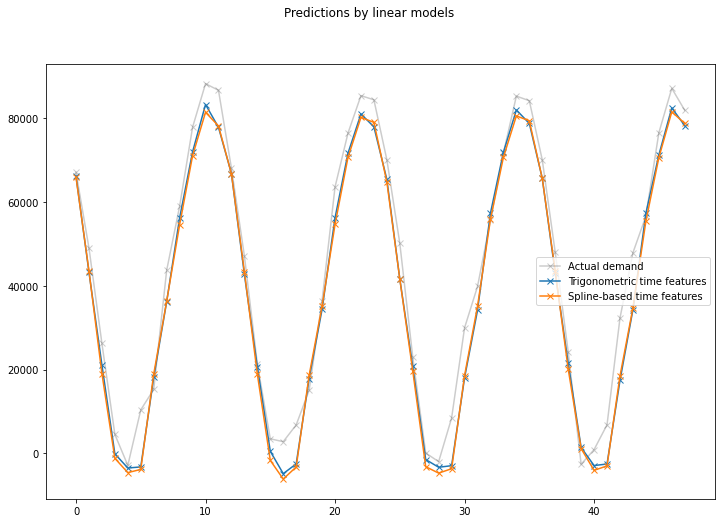

In [132]:
last_months = slice(-48, None)
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("Predictions by linear models")
ax.plot(
    y.iloc[test_0].values[last_months],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    cyclic_cossin_linear_predictions[last_months],
    "x-",
    label="Trigonometric time features",
)
ax.plot(
    cyclic_spline_linear_predictions[last_months],
    "x-",
    label="Spline-based time features",
)
_ = ax.legend()

In [133]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion


hour_workday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("workingday", FunctionTransformer(lambda x: x == "True"), ["workingday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

In [134]:
cyclic_spline_interactions_pipeline = make_pipeline(
    FeatureUnion(
        [
            ("marginal", cyclic_spline_transformer),
            ("interactions", hour_workday_interaction),
        ]
    ),
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_interactions_pipeline, X, y, cv=ts_cv)

ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexes\base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'hour'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\__init__.py", line 416, in _get_column_indices
    col_idx = all_columns.get_loc(col)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexes\base.py", line 3623, in get_loc
    raise KeyError(key) from err
KeyError: 'hour'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 1154, in fit_transform
    results = self._parallel_func(X, y, fit_params, _fit_transform_one)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 1176, in _parallel_func
    return Parallel(n_jobs=self.n_jobs)(
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 1046, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 414, in fit_transform
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\compose\_column_transformer.py", line 670, in fit_transform
    self._validate_column_callables(X)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\compose\_column_transformer.py", line 357, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\__init__.py", line 424, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


In [135]:
from sklearn.kernel_approximation import Nystroem


cyclic_spline_poly_pipeline = make_pipeline(
    cyclic_spline_transformer,
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_poly_pipeline, X, y, cv=ts_cv)

C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\kernel_approximation.py:921: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(


Mean Absolute Error:     4464.070 +/- 1206.421
Root Mean Squared Error: 5783.469 +/- 1475.134


{'fit_time': array([0.04848981, 0.14907122, 0.21110106]),
 'score_time': array([0.00700474, 0.00700045, 0.00700355]),
 'test_neg_mean_absolute_error': array([-6169.46381313, -3654.98952108, -3567.75639764]),
 'test_neg_root_mean_squared_error': array([-7868.92923386, -4787.33870892, -4694.14024611])}

In [144]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
one_hot_poly_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("one_hot_time", one_hot_encoder, ["dayofweek", "month"]),
        ],
        remainder="passthrough",
    ),
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)
evaluate(one_hot_poly_pipeline, X, y, cv=ts_cv)

C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\kernel_approximation.py:921: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(


Mean Absolute Error:     4231.600 +/- 617.239
Root Mean Squared Error: 5455.039 +/- 711.056


{'fit_time': array([0.01499915, 0.1295054 , 0.20046329]),
 'score_time': array([0.0070188, 0.       , 0.       ]),
 'test_neg_mean_absolute_error': array([-5080.27352148, -3984.15302674, -3630.37285815]),
 'test_neg_root_mean_squared_error': array([-6457.58839662, -5021.37683546, -4886.15208178])}

In [121]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=3,
    gap=12,
    max_train_size=1000,
    test_size=452,
)

In [122]:
X = df_berk.drop(['timeseries-tas-monthly-mean', 'time'], axis=1)
y = df_berk['timeseries-tas-monthly-mean']

In [94]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

In [95]:
from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [96]:
df_berk["sin_week"] = sin_transformer(7).fit_transform(df_berk['week'])
df_berk["sin_month"] = sin_transformer(12).fit_transform(df_berk['month'])
df_berk["sin_quarter"] = sin_transformer(4).fit_transform(df_berk['quarter'])
df_berk["sin_dayofyear"] = sin_transformer(365).fit_transform(df_berk['dayofyear'])
df_berk['sin_day_of_week'] = sin_transformer(7).fit_transform(df_berk['dayofweek'])

df_berk["cos_week"] = cos_transformer(7).fit_transform(df_berk['week'])
df_berk["cos_month"] = cos_transformer(12).fit_transform(df_berk['month'])
df_berk["cos_quarter"] = cos_transformer(4).fit_transform(df_berk['quarter'])
df_berk["cos_dayofyear"] = cos_transformer(365).fit_transform(df_berk['dayofyear'])
df_berk['cos_day_of_week'] = cos_transformer(7).fit_transform(df_berk['dayofweek'])

In [145]:
one_hot_poly_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_poly_predictions = one_hot_poly_pipeline.predict(X.iloc[test_0])

cyclic_spline_poly_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_poly_predictions = cyclic_spline_poly_pipeline.predict(X.iloc[test_0])

C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\kernel_approximation.py:921: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\kernel_approximation.py:921: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(


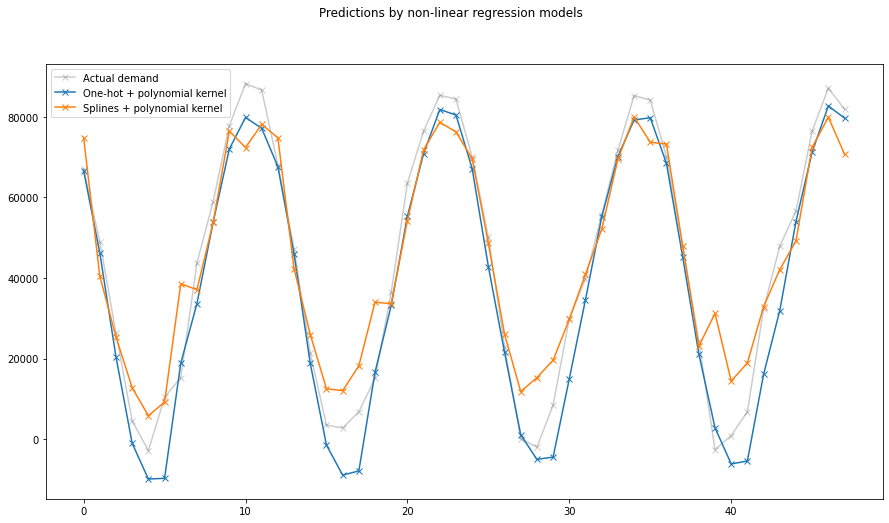

In [150]:
last_months = slice(-48, None)
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle("Predictions by non-linear regression models")
ax.plot(
    y.iloc[test_0].values[last_months],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    one_hot_poly_predictions[last_months],
    "x-",
    label="One-hot + polynomial kernel",
)
ax.plot(
    cyclic_spline_poly_predictions[last_months],
    "x-",
    label="Splines + polynomial kernel",
)
_ = ax.legend()

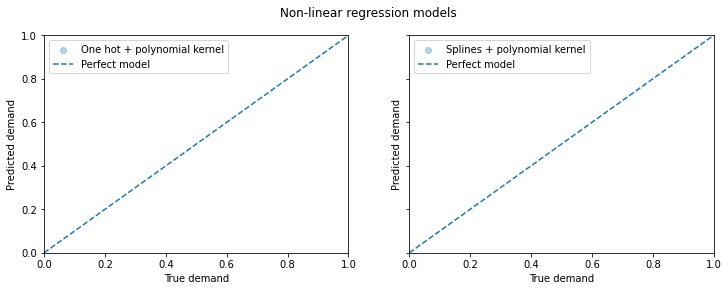

In [148]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    one_hot_poly_predictions,
    cyclic_spline_poly_predictions,
]
labels = [
    "One hot + polynomial kernel",
    "Splines + polynomial kernel",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 1], [0, 1], "--", label="Perfect model")
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()

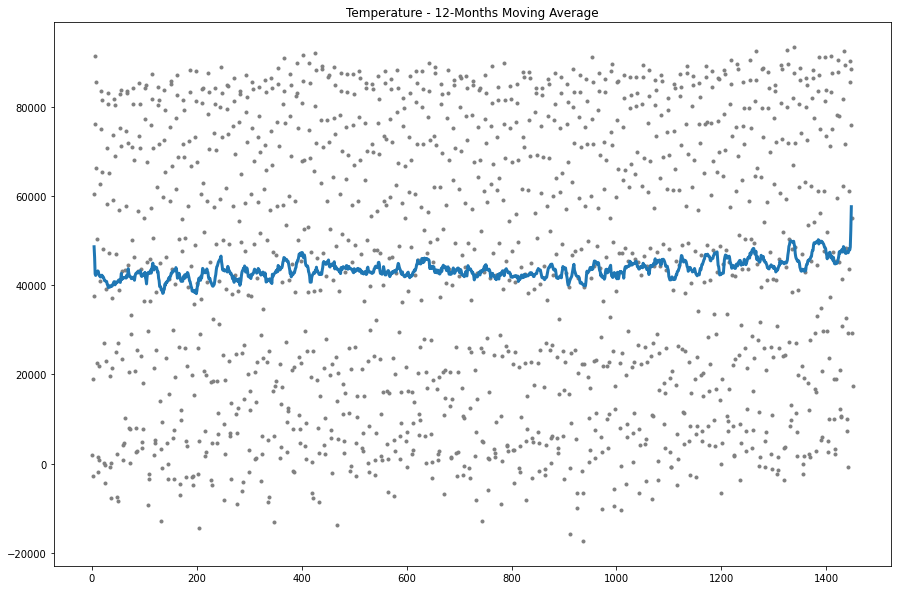

In [155]:
moving_average = df_berk['timeseries-tas-monthly-mean'].rolling(
    window=12,
    center=True,   
    min_periods=10,
).mean()              

ax = df_berk['timeseries-tas-monthly-mean'].plot(style=".", color="0.5", figsize=(15, 10))
moving_average.plot(
    ax=ax, linewidth=3, title="Temperature - 12-Months Moving Average", legend=False,
);

In [157]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df_berk['time'],
    constant=True,
    order=1,
    drop=True,
)
X = dp.in_sample()

X.head()

,const,trend
time,,
1901-01-31,1.0,1.0
1901-02-28,1.0,2.0
1901-03-31,1.0,3.0
1901-04-30,1.0,4.0
1901-05-31,1.0,5.0


In [158]:
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

In [159]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [169]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
         _, ax = plt.subplots(figsize=(15, 10))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

C:\Users\lenovo\AppData\Local\Temp\ipykernel_18724\2768580527.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  X["week"] = X['time'].dt.week


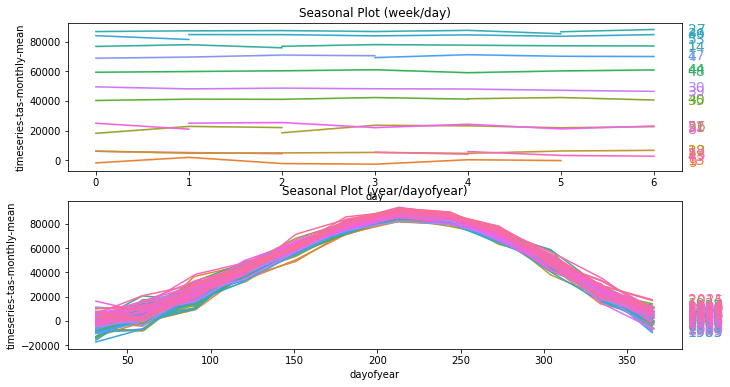

In [237]:
import seaborn as sns

X = df_berk.copy()

X["day"] = X['time'].dt.dayofweek
X["week"] = X['time'].dt.week

X["dayofyear"] = X['time'].dt.dayofyear
X["year"] = X['time'].dt.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="timeseries-tas-monthly-mean", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="timeseries-tas-monthly-mean", period="year", freq="dayofyear", ax=ax1);

C:\Users\lenovo\AppData\Local\Temp\ipykernel_18724\2641284335.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(df_berk['timeseries-tas-monthly-mean'])


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

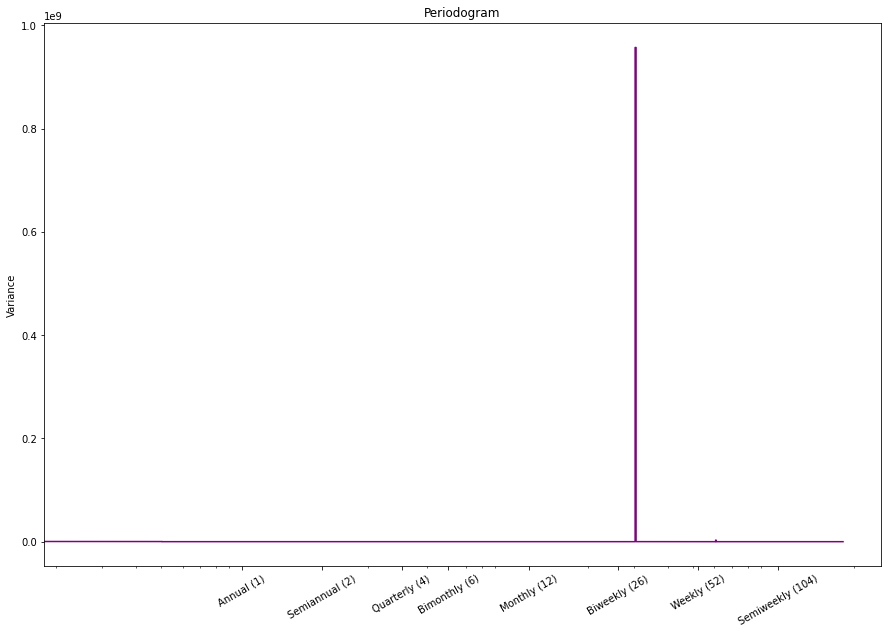

In [238]:
plot_periodogram(df_berk['timeseries-tas-monthly-mean'])

In [239]:
from sklearn.linear_model import LinearRegression

In [240]:
fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=df_berk['time'],
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

In [241]:
X.head()

,const,trend,"s(2,12)","s(3,12)","s(12,12)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
time,,,,,,,,,,,,,,,,,,,,,
1901-01-31,1.0,1.0,0.0,0.0,0.0,0.493776,0.869589,0.858764,0.512371,0.999769,...,0.043022,-0.999074,-0.455907,-0.890028,-0.835925,-0.548843,-0.997917,-0.064508,-0.899631,0.436651
1901-02-28,1.0,2.0,1.0,0.0,0.0,0.840618,0.541628,0.910605,-0.413279,0.145799,...,-0.288482,0.957485,0.648630,0.761104,0.991114,-0.133015,0.425000,-0.905193,-0.530730,-0.847541
1901-03-31,1.0,3.0,0.0,1.0,0.0,0.999250,0.038722,0.077386,-0.997001,-0.993257,...,0.230306,-0.973118,-0.963471,-0.267814,-0.304921,0.952378,0.939856,0.341571,0.377708,-0.925925
1901-04-30,1.0,4.0,0.0,0.0,0.0,0.888057,-0.459733,-0.816538,-0.577292,-0.137279,...,-0.271958,0.962309,0.979614,-0.200891,-0.628763,-0.777597,-0.401488,0.915864,0.997917,-0.064508
1901-05-31,1.0,5.0,0.0,0.0,0.0,0.530730,-0.847541,-0.899631,0.436651,0.994218,...,0.213521,-0.976938,-0.699458,0.714673,0.972118,-0.234491,-0.948362,-0.317191,0.635432,0.772157


In [248]:
X.reset_index(inplace=True)
X['time'] = pd.to_datetime(X['time'])
X = X.set_index(pd.PeriodIndex(X['time'])).to_period('M')

TypeError: Passing PeriodDtype data is invalid. Use `data.to_timestamp()` instead

In [243]:
X.index

PeriodIndex(['1901-01', '1901-02', '1901-03', '1901-04', '1901-05', '1901-06',
             '1901-07', '1901-08', '1901-09', '1901-10',
             ...
             '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08',
             '2021-09', '2021-10', '2021-11', '2021-12'],
            dtype='period[M]', name='time', length=1452)

In [244]:
X.drop(['time'], axis=1, inplace=True)

In [245]:
y = df_berk["timeseries-tas-monthly-mean"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=12)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:435: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:691: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit incremen

TypeError: CalendarFourier terms can only be computed from DatetimeIndex and PeriodIndex

In [253]:
from statsmodels.graphics.tsaplots import plot_pacf

C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


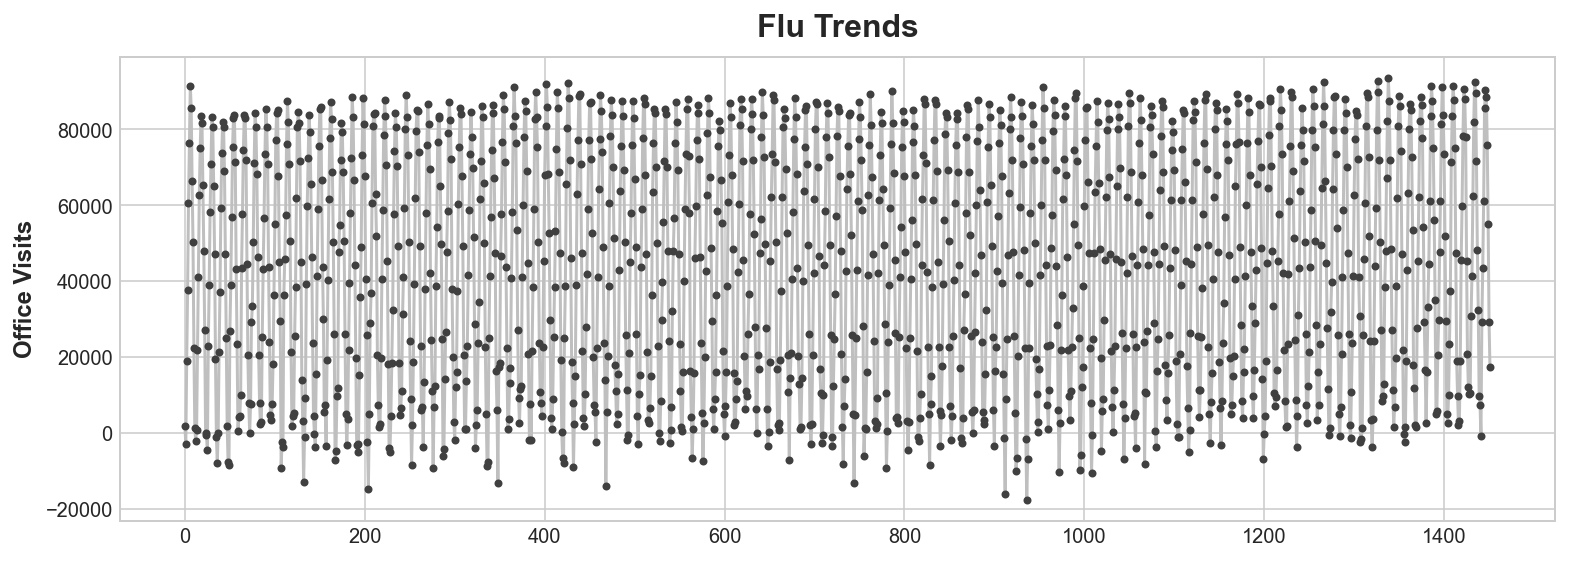

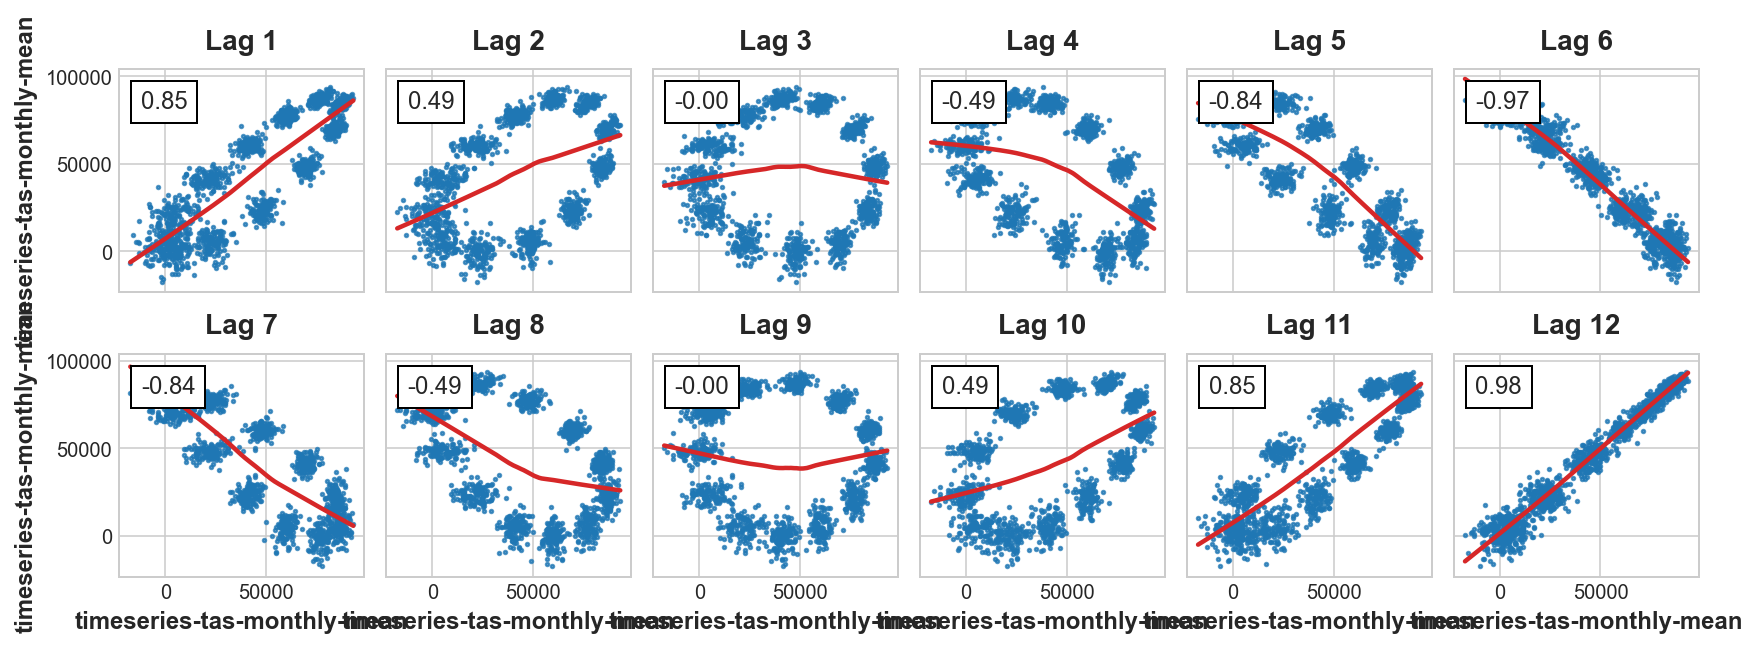

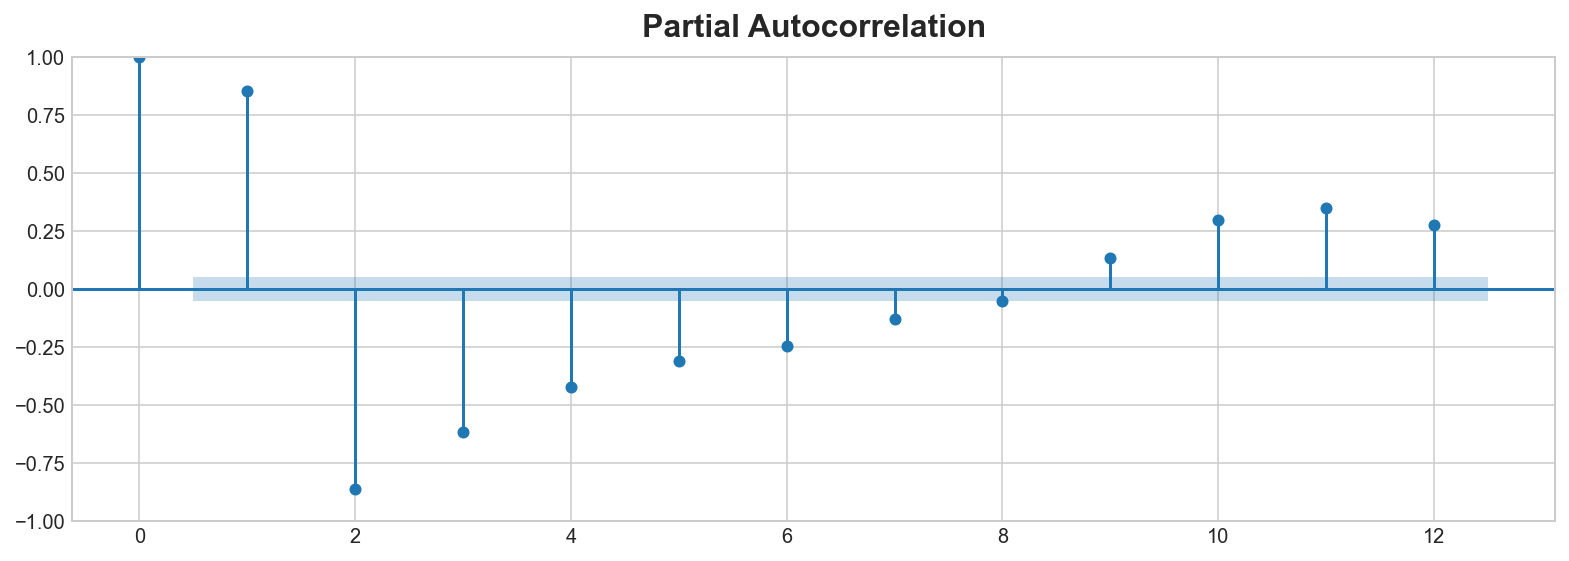

In [254]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

ax = df_berk['timeseries-tas-monthly-mean'].plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")
_ = plot_lags(df_berk['timeseries-tas-monthly-mean'], lags=12, nrows=2)
_ = plot_pacf(df_berk['timeseries-tas-monthly-mean'], lags=12)

In [256]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(df_berk['timeseries-tas-monthly-mean'], lags=4)
X = X.fillna(0.0)

In [259]:
# Create target series and data splits
from sklearn.model_selection import train_test_split

y = df_berk['timeseries-tas-monthly-mean'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

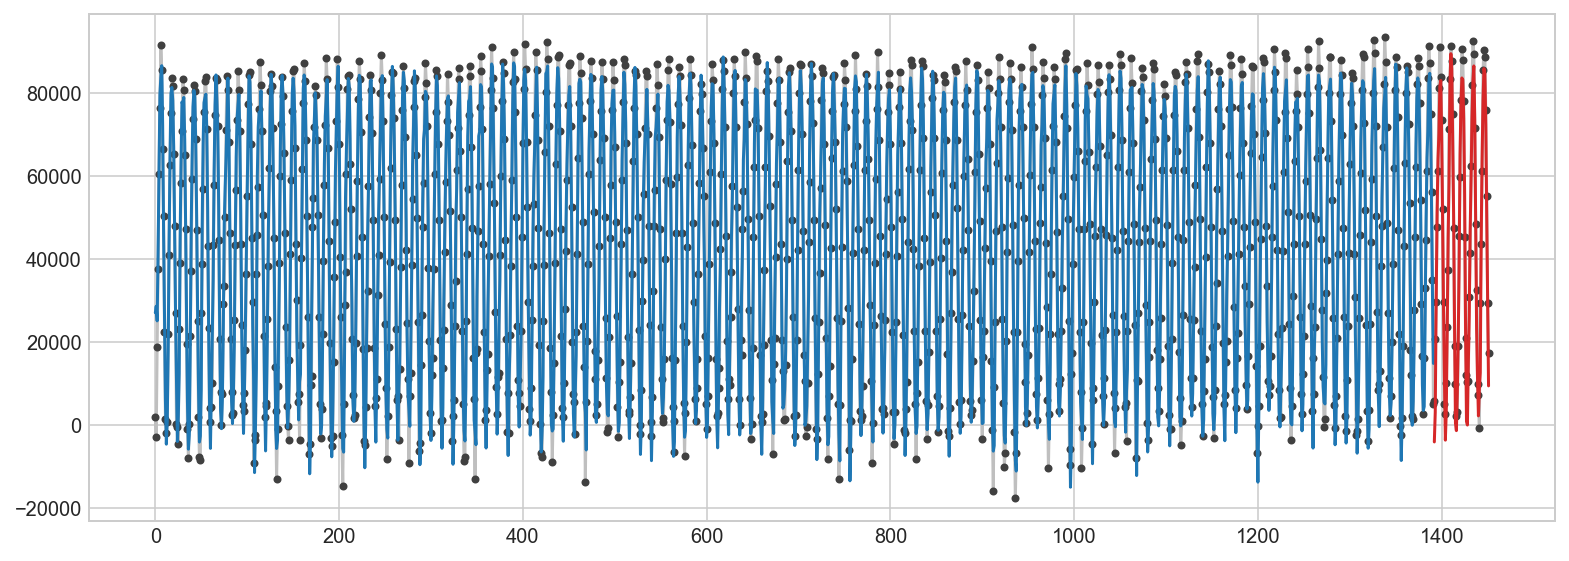

In [260]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

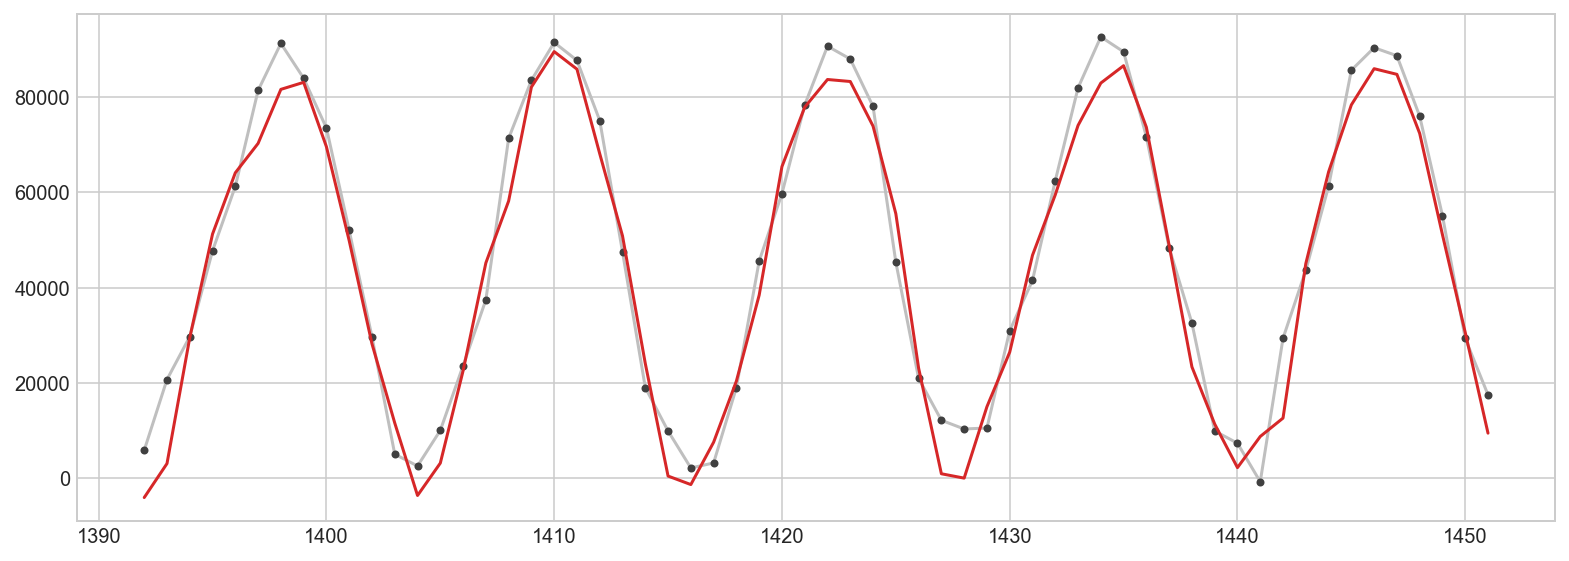

In [261]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_18724\3677016453.py:46: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_18724\3677016453.py:47: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_18724\3677016453.py:48: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)


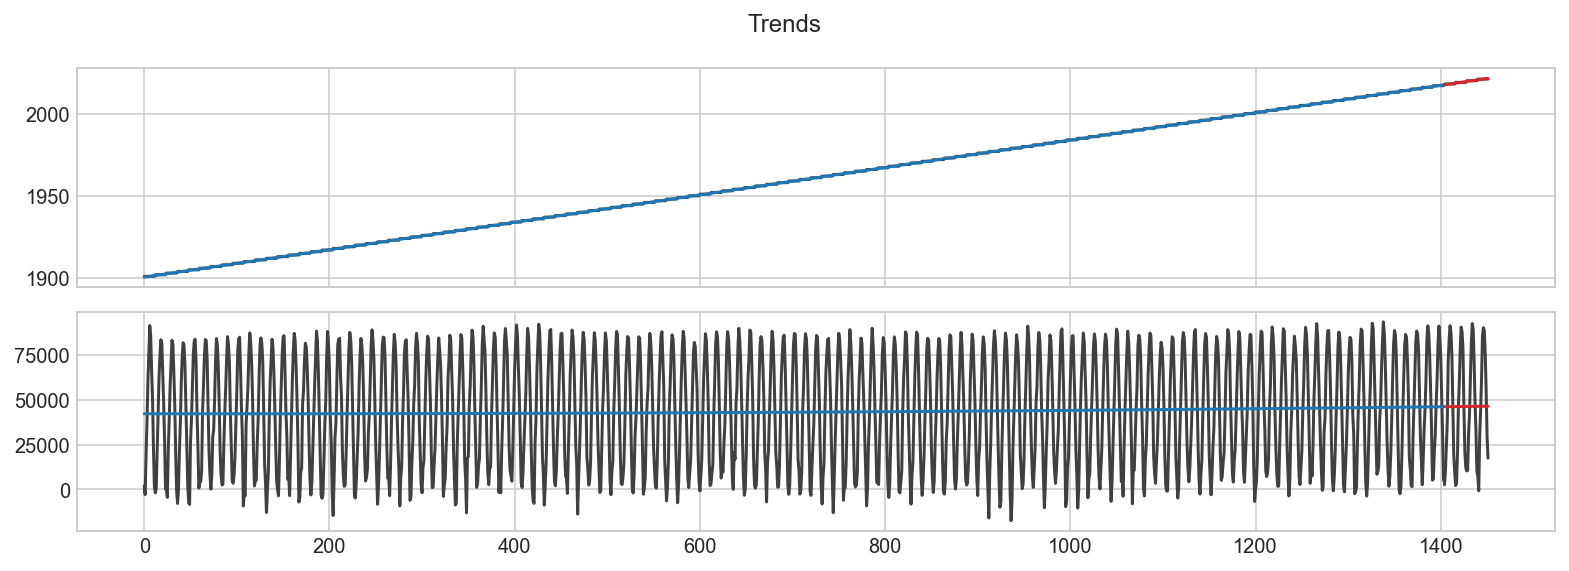

In [276]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


y = df_berk[['year', 'timeseries-tas-monthly-mean']].copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [307]:
def plot_multistep(y, every=30, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

df = pd.read_csv('BERK.csv')
df.set_index(
    pd.PeriodIndex(df.time, freq="W"),
    inplace=True,
)


def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = df_berk['timeseries-tas-monthly-mean'].copy()
X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)
# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [308]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [309]:
from sklearn.metrics import mean_squared_error

Train RMSE: 6497.65
Test RMSE: 7506.69


DateParseError: day is out of range for month

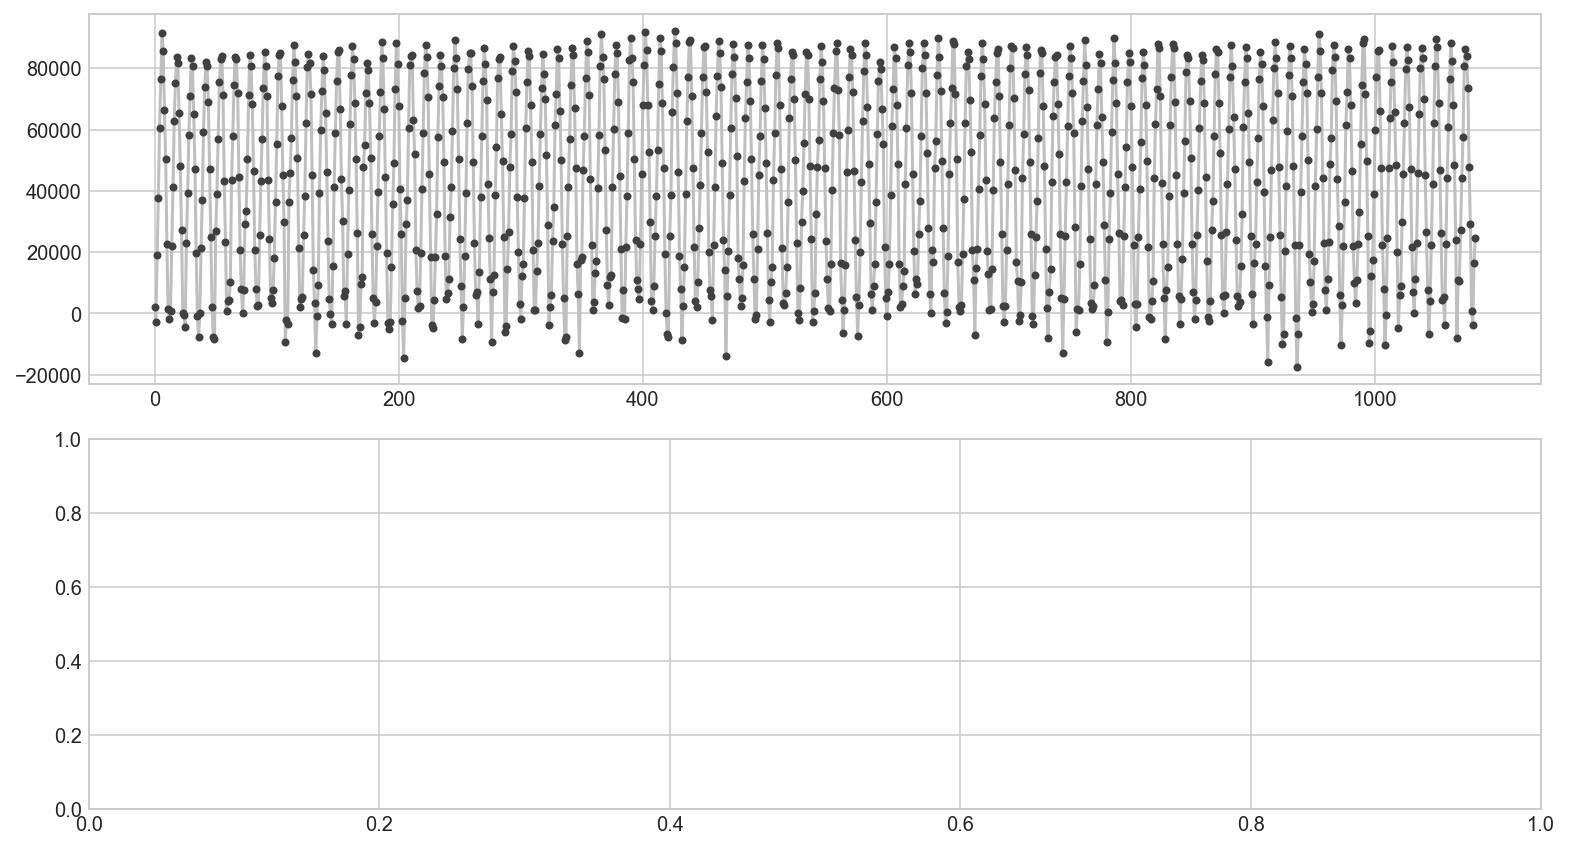

In [310]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = df_berk['timeseries-tas-monthly-mean'][y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = df_berk['timeseries-tas-monthly-mean'][y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

In [288]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 965.07
Test RMSE: 6488.61


DateParseError: day is out of range for month

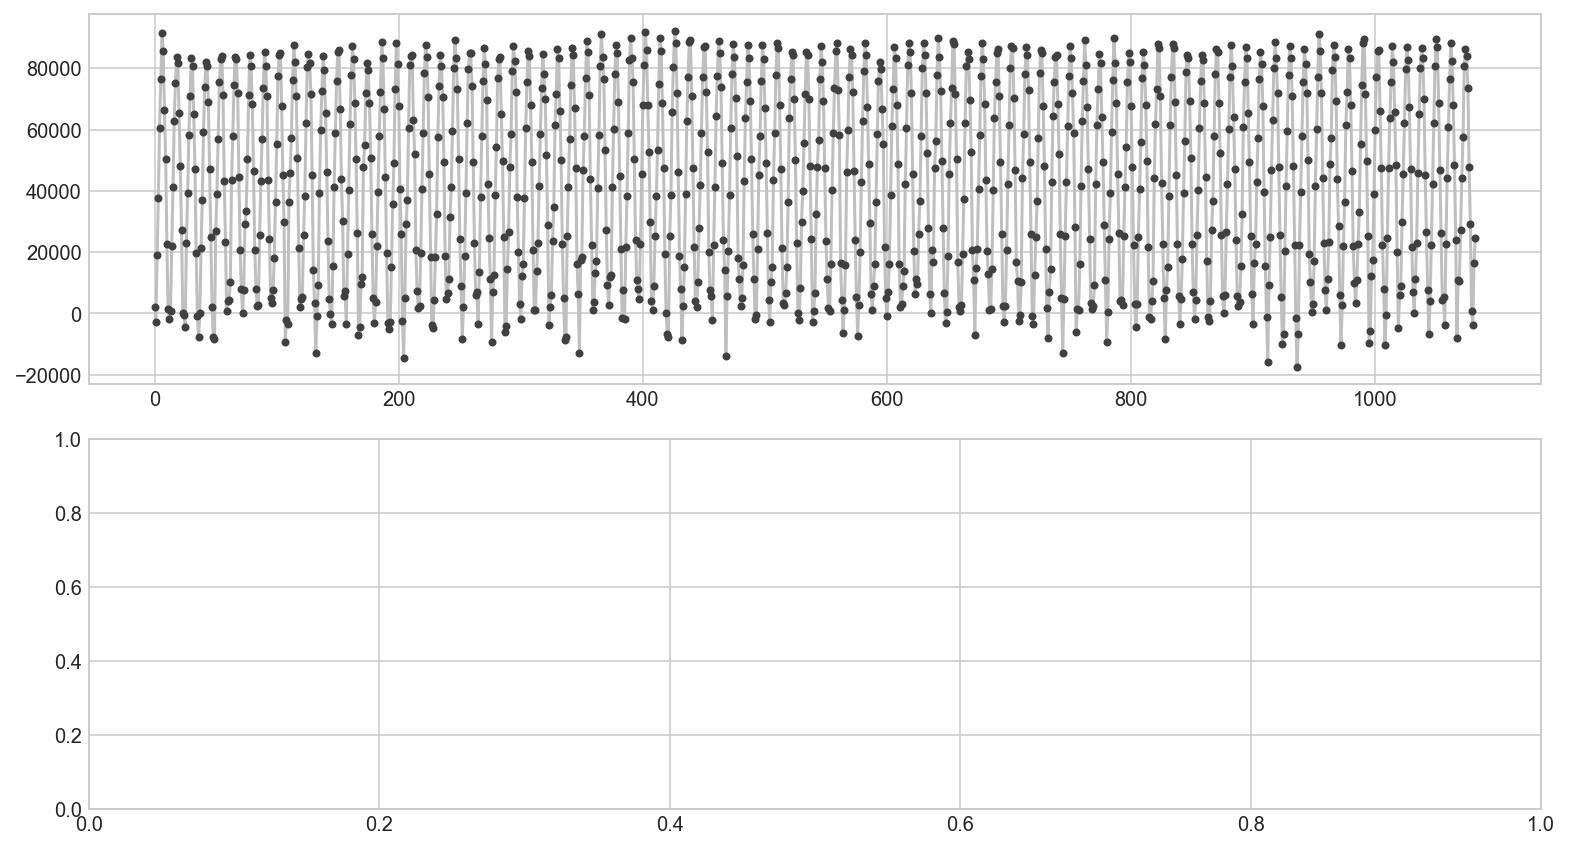

In [290]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = df_berk['timeseries-tas-monthly-mean'][y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = df_berk['timeseries-tas-monthly-mean'][y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])